# Apresentação ✒️

Notebook destinado ao estudo da criação de AgentsAI, com LangChain e LangGraph, uma biblioteca presente no ecosistema do LangChain, sendo útil na elaboração de worflows entre Agents e ferramentas, permitindo a criação de uma memória de estado a cada interação e a relação entre os itens presentes nesse tipo de fluxo, baseado em grafos.

Para a sua construção, apresenta três componentes principais :

>

- State :     

Persistência de informação na arquitetura, que cria um tipo de estado interno (memória) para a aplicação, guardando as informações novas que são geradas a cada interação, havendo dois principais tipos : aditiva e a complexa.

A primeira apenas adiciona uma nova informação no ciclo de mensagens do sistema de uso, informando à ao modelo de linguagem as informações obtidas, enquanto o segundo sobre-escreve a informação anterior pela nova, mantendo porém cada etapa intermediária gerada.

>

- Node :     

Refere-se aos nós presentes nos grafos e aqui representam tanto os Agents quanto as ferramentas que podem ser utilizadas por esses. Por conta do mecanismo do State, apresentam a capacidade de ter estado interno, que serve como memória para cada qual, tornando o sistema efetivo para a realização das atividades.

>

- Edge :     

Refere-se a linha, o caminho que conecta cada nó entre si (Agent e ferramenta), sendo as rotas pelas quais a informação é passada.

### Observação !

Ainda há os conditionals nodes, que são nós condicionais que realizam o processo lógico da possibilidade da informação ir ou não adiante com base na informação gerada pelos Agents nodes e tool nodes. Por exemplo, se um Agent determinado precisa de uma entada para realizar a sua tarefa, a qual é direcionada para outro, esse nó analisaria se a tarefa desse já foi ou não realizada, permitindo ou não a propagação ao longo da rede.



## Imagem

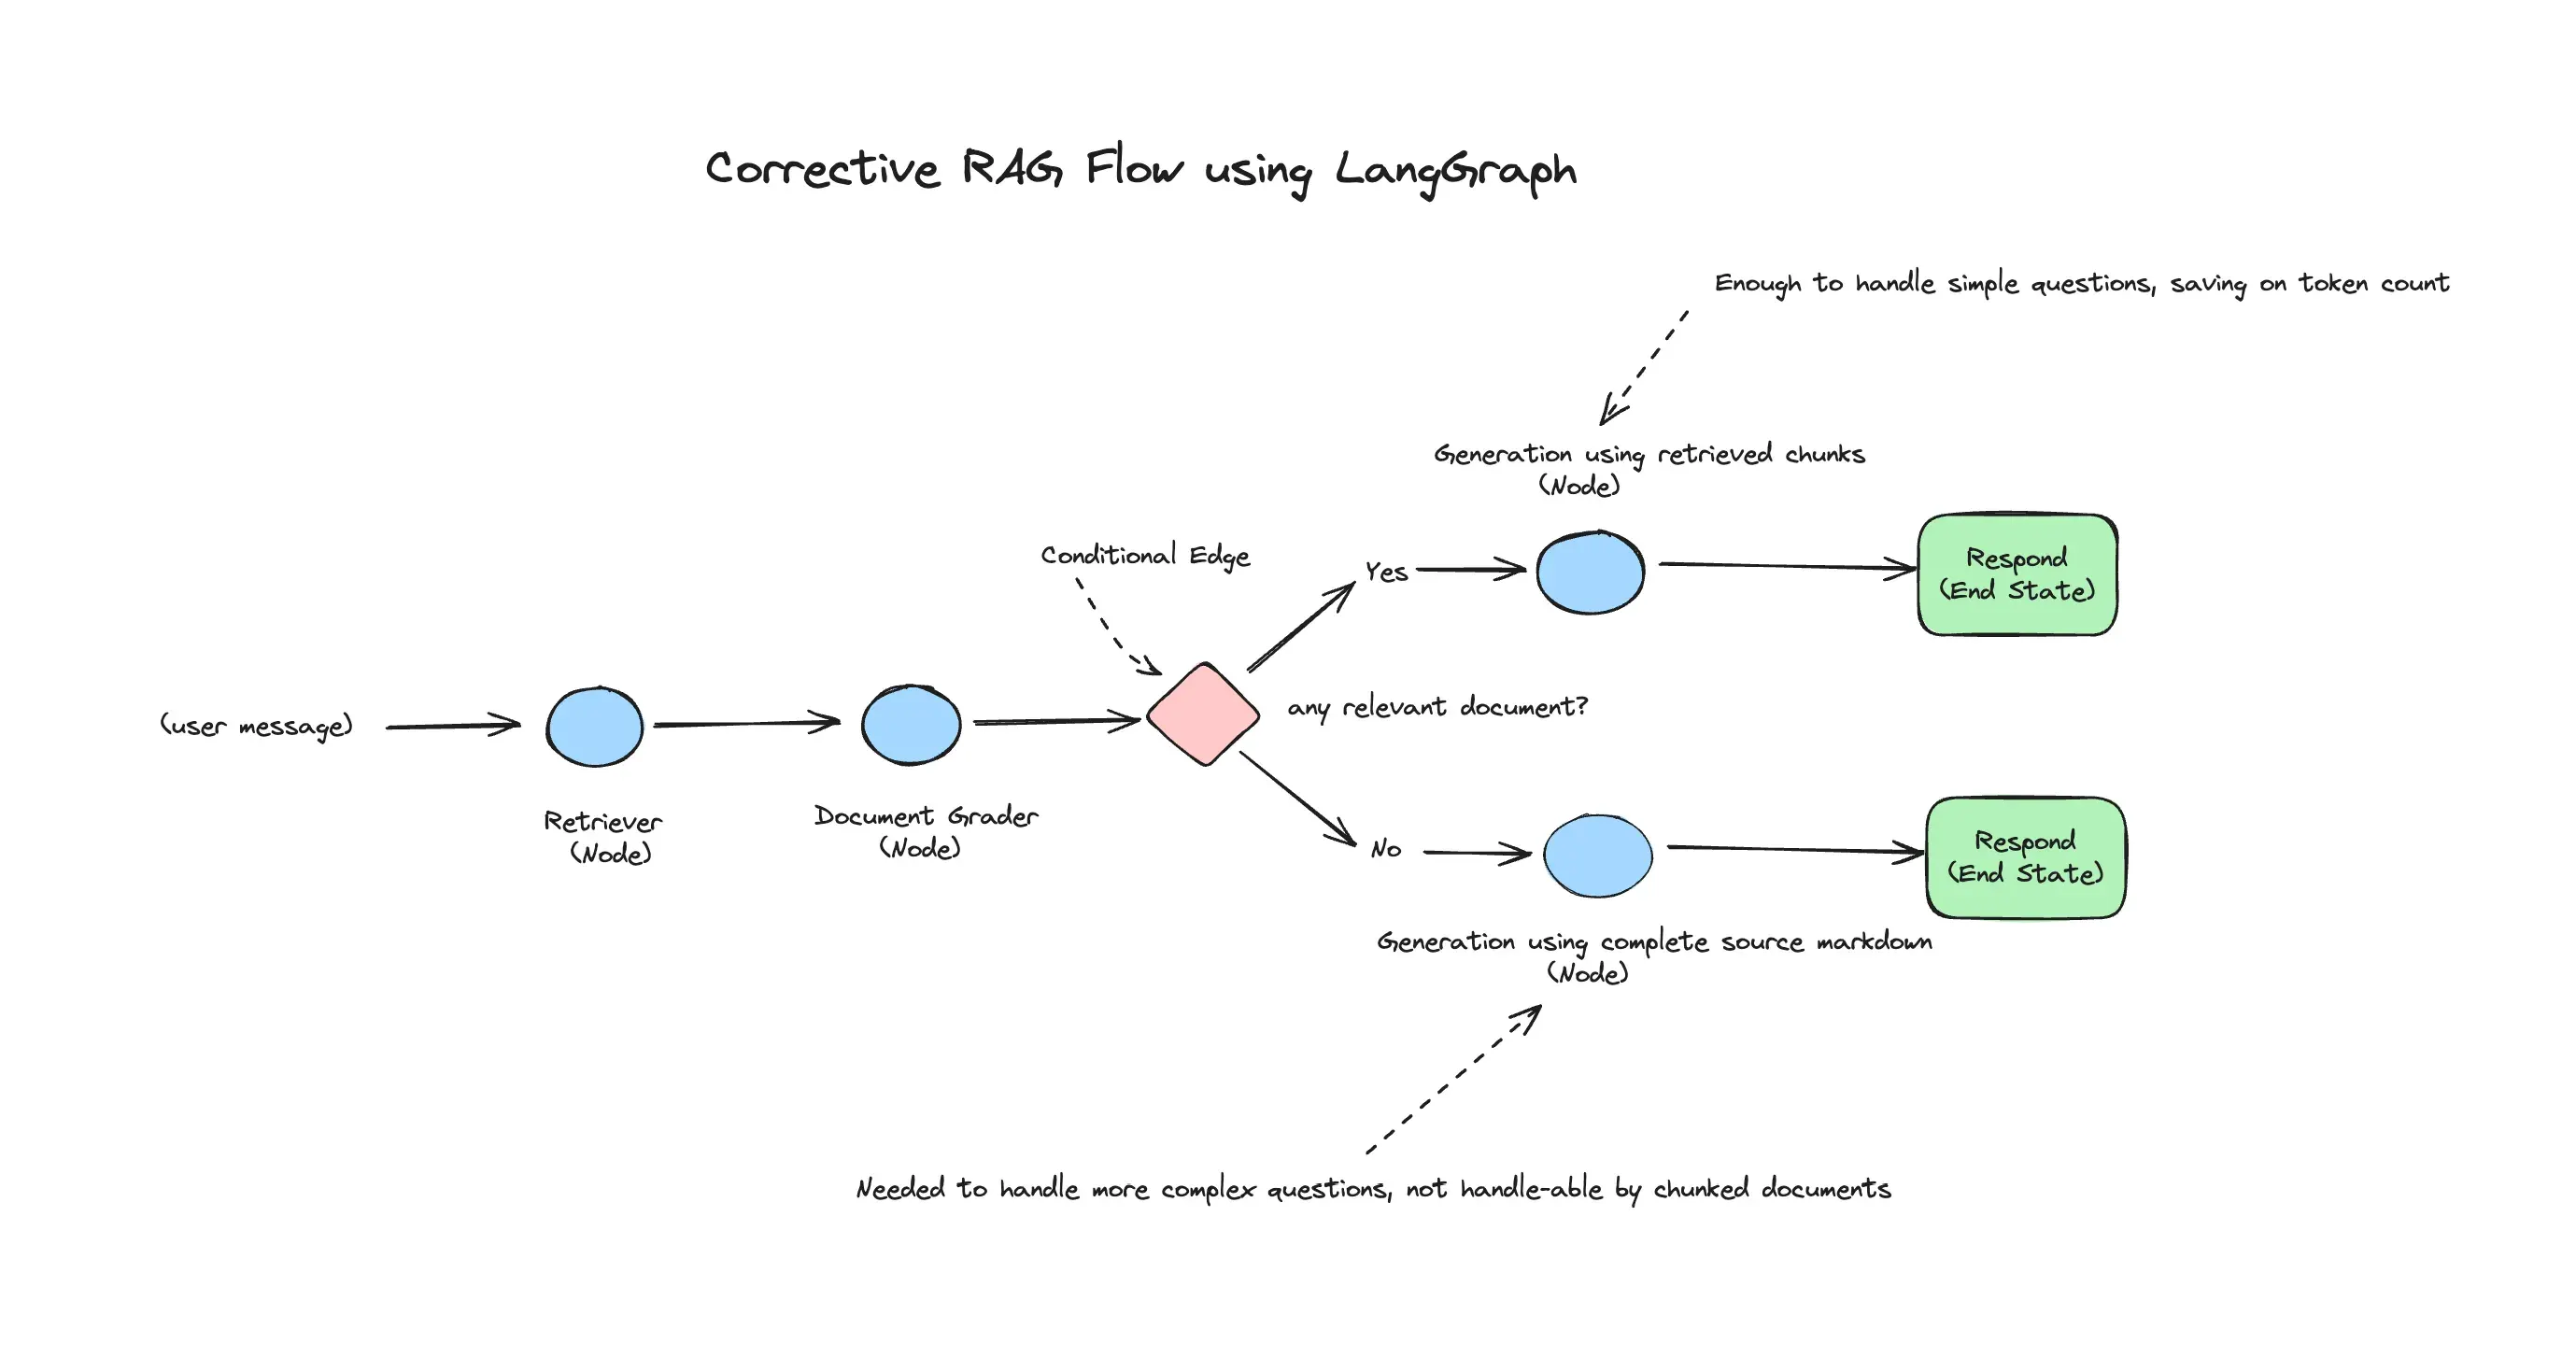

## Biblioteca 📚

In [ ]:
!pip install langgraph -q
!pip install langchain -q
!pip install langchain-community -q
!pip install langchain_google_genai -q
!pip install google-generativeai -q

In [ ]:
import os
import getpass
import operator
import markdown
import warnings
warnings.filterwarnings("ignore")
import google.generativeai as genai

from IPython.display import Image
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults


## Definindo as variáveis de ambiente 🧩

In [ ]:
os.environ["GOOGLE_API_KEY"] = "sua-api-key"

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
os.environ["TAVILY_API_KEY"] = getpass.getpass()

··········


In [ ]:
# Testando a conexão API :

list_model = genai.list_models()

for models in list_model:
  print(models.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash
models/embedding-001
models/text-embedding-004
models/aqa


In [ ]:
# Instanciando o modelo de uso.

model = ChatGoogleGenerativeAI(
    model = "gemini-1.5-pro-latest",
    temperature = 0.5,
    max_output_tokens = 2048,

)

In [ ]:
response = model.predict("""
                        Os personagens do universo do Batman representam a personificação
                        de um transtorno mental ?
                        """)


In [ ]:
response

'É uma pergunta interessante e que rende uma boa discussão! Muitos personagens do universo Batman, tanto heróis quanto vilões, exibem características que lembram transtornos mentais, mas é importante ter cuidado ao rotulá-los. \n\n**Por que pensar que sim:**\n\n* **Trauma como base:** Grande parte dos personagens, principalmente os vilões, são definidos por traumas de infância. A perda dos pais de Bruce Wayne, a infância abusiva de Harley Quinn, a obsessão de Duas-Caras por dualidade após o trauma com ácido, entre outros, são exemplos claros.\n* **Características exageradas:** A própria natureza das histórias em quadrinhos, que muitas vezes busca por elementos dramáticos e exagerados, amplifica características que poderiam ser associadas a transtornos mentais. O pânico do Espantalho, a obsessão do Charada, a instabilidade do Coringa, são alguns exemplos.\n* **Reflexo da sociedade:** Os quadrinhos, como forma de arte, refletem a sociedade em que são criados. As representações de saúde m

## Criando a ferramenta (Tavily Search)

A ferramenta utilizada para a criação desse Agent AI com LangGraph será o TavilySearch, responsável por realizar consultas na internet, por meio da similaridade semântica e outros métodos, sendo muito utilizado para implementações com IAs generativas e AgentsAI.

In [ ]:
# Instanciando a ferramenta e passando como argumento,
# uma quantidade de resultados retornados de no máximo
# 5 documentos.

tool = TavilySearchResults(
    max_results = 5
)

In [ ]:
# Visualizando o nome da ferramenta e o seu tipo.
# O nome informado indica o nome do language model,
# responsável pela elaboração da ferramenta.

print(tool.name, "\n", type(tool))

tavily_search_results_json 
 <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>


## Criando o Agent com LangGraph

In [ ]:
# Criando o componente State, responsável pela
# persistência de informação na arquitetura de grafos.

class AgentState(TypedDict):
  messages : Annotated[list[AnyMessage], operator.add]

In [ ]:
# Criando o Agent :

class Agent:

  def __init__(self, model, tools, system = ""):

    self.system = system

    graph = StateGraph(AgentState)

    graph.add_node("llm", self.call_gemini)
    graph.add_node("action", self.take_action)
    graph.add_conditional_edges(
        "llm",
        self.exists_actions,
        {True : "action", False : END}
    )
    graph.add_edge("action", "llm")

    graph.set_entry_point("llm")

    self.graph = graph.compile()
    self.tools = {tool.name : tool for tool in tools}
    self.model = model.bind_tools(tools)

  # Função que analisa se há a necessidade de realizar
  # ações existentes, a partir da vericação da última mensagem
  # do dicionário state, por meio de uma operação booleana.

  # Se há funções de chamada, o valor é True, mantendo
  # a ação; se não, finalizasse a ação.

  def exists_actions(self, state : AgentState):

    result = state["messages"][-1]
    return len(result.tool_calls) > 0

  # Função que chama o modelo de linguagem (LLM)
  # para gerar respostas com base nas mensagens atuais
  # do estado presente.

  def call_gemini(self, state: AgentState):

    # Atribui as mensagens no estado à variável messages.

    messages = state["messages"]

    # Se há um sistema, cria uma nova lista de mensagens,
    # contendo uma única SystemMessage como o conteúdo do sistema.

    if self.system:
      messages = [SystemMessage(content = self.system)] + messages

    # Invoca o modelo para gerar uma nova mensagem,
    # que gera e retorna um novo estado com a nova
    # mensagem gerada.

    message = self.model.invoke(messages)
    return {"messages": [message]}

  # Função que executa as ações determinadas em tool_calls
  # e atualiza o estado com o resultado das ações.

  def take_action(self, state: AgentState):

        # Extrai as chamadas das ferramentas da última mensagem
        # do estado.

        tool_calls = state['messages'][-1].tool_calls

        # Cria-se uma lista para armazenar o resultado das ações.

        results = []

        # Cria um ciclo iterativo para verificar a qualidade da
        # ferramenta e realizar o tratamento de erros, além de retornar
        # a ferramenta utilizada, no que se refere ao seu id, nome e conteúdo.

        for tool in tool_calls:
            print(f"Calling: {tool}")

            if not tool['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[tool['name']].invoke(tool['args'])

            results.append(ToolMessage(tool_call_id=tool['id'],
                                       name=tool['name'],
                                       content=str(result)))

        # Atualiza o estado com os resultados das ações
        state["messages"].extend(results)
        print("Back to the model!")

        return {"messages": state["messages"]}

In [ ]:
# Criando um prompt a partir do qual o Agent terá que
# personificar em ordem de realizar as atividades que
# lhe são propostas.

prompt = ("""
          You are a smart research assistant. Use the search engine to look up information. \
          You are allowed to make multiple calls (either together or in sequence). \
          Only look up information when you are sure of what you want. \
          If you need to look up some information before asking a follow up question, you are allowed to do that!
          """)

# Instanciando o Agent, passando para ele como argumentos
# o modelo de LLM utilizado, a(s) ferramenta(s) e o prompt
# a partir do qual deve se guiar em ordem de cumprir com a
# resolução das tarefas a ele informadas.

agentBot = Agent(model, [tool],
                 system = prompt)

## Realizando consultas

In [ ]:
prompt_1 = ("Who was Ayrton Senna ?")

prompt_2 = ("""
            Where did the cyberpunk genre and aesthetic originate?
            What does she propose ?
           """)

prompt_3 = ("Who is better in formula one statics Merceds or RedBull ?")

### Primeira consulta

In [ ]:
messages = [HumanMessage(content = prompt_1)]

result = agentBot.graph.invoke({"messages" : messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Ayrton Senna'}, 'id': '4b19efea-640b-4bb7-afb2-028d32ce90a8', 'type': 'tool_call'}
Back to the model!


In [ ]:
# Visualizando a resposta encontrada.

result["messages"][-1].content

"Ayrton Senna was a Brazilian racing driver who won the Formula One World Drivers' Championship three times, in 1988, 1990, and 1991. \n"

In [ ]:
messages = [HumanMessage(content = "")]

## Segunda consulta

In [ ]:
messages = [HumanMessage(content = prompt_2)]

result = agentBot.graph.invoke({"messages" : messages})

# Visualizando a resposta encontrada.

print("")
result["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Where did the cyberpunk genre and aesthetic originate?'}, 'id': 'a33abed1-cb73-4e30-a912-36f148f91f69', 'type': 'tool_call'}
Back to the model!



'The cyberpunk genre and aesthetic originated in the 1970s, solidifying in the 1980s with works like Bruce Bethke\'s short story "Cyberpunk" (1980) and the Japanese manga "Akira" (1982). Its roots can be traced back to even earlier decades, with influences from 1940s and 1950s technological fiction and the writings of authors like Samuel R. Delany. \n\nThe question "What does she propose?" is unclear. There is no mention of a "she" in the provided context. Please provide more information. \n'

## Terceira consulta

In [ ]:
messages = [HumanMessage(content = prompt_3)]

result = agentBot.graph.invoke({"messages" : messages})

# Visualizando a resposta encontrada.

print("")
result["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Formula One constructors championships won'}, 'id': 'd453263e-f113-4332-a22b-32f5f4e6057b', 'type': 'tool_call'}
Back to the model!



"Mercedes and Red Bull both have won the Formula One Constructors' Championship eight times. \n"